## **Optimising the initial random weights for params**

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
 words = open('names.txt', 'r').read().splitlines()
 words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
vocab_size = len(itos)
vocab_size

27

In [6]:
block_size = 3 # context length: how many characters do we take to predict the next one

def build_dataset(words):
  # build the dataset

  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '---->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [7]:
import random

random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g,requires_grad= True)

# Weights and bias
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g, requires_grad= True)
b1 = torch.randn(n_hidden, generator=g,requires_grad= True)

W2 = torch.randn((n_hidden, vocab_size), generator=g,requires_grad= True)
b2 = torch.randn(vocab_size, generator=g,requires_grad= True)

parameters = [C, W1, b1, W2, b2]

In [9]:
lr = 0.12
epochs = 70000
batch_size = 32
losses = []

for epoch in range(epochs + 1):

  # minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))

  # forward pass
  emb = C[Xtr[ix]]   # (batch_size, 2, 3)
  embcat = emb.view(emb.shape[0], -1)   # (batch_size, 6)
  hpreact = embcat @ W1 + b1  # (batch_size, n_hidden)
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2   # (batch_size, vocab_size)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update parameters
  for p in parameters:
    p.data += -lr * p.grad

  if epoch % 10000 == 0:
    print(f'{epoch} / {epochs}: {loss.item() : .4f}')
  losses.append(loss.item())

0 / 70000:  27.5681
10000 / 70000:  2.4071
20000 / 70000:  2.3620
30000 / 70000:  2.4015
40000 / 70000:  2.2958
50000 / 70000:  2.1923
60000 / 70000:  2.6187
70000 / 70000:  2.6092


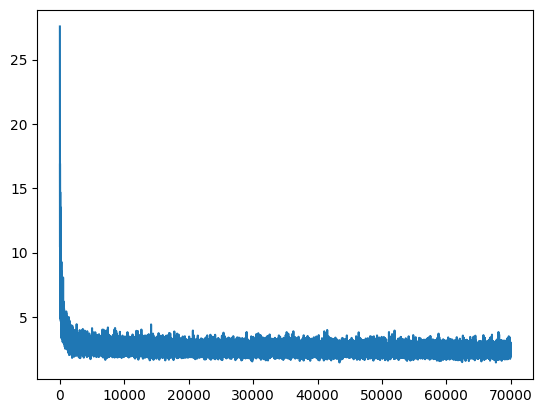

In [10]:
plt.plot(range(epochs + 1), losses)

In [11]:
@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xval, Yval),
      'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embed)
  embcat = emb.view(emb.shape[0], -1)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.3167874813079834
val 2.355640172958374


In [12]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

eriah.
myan.
heelen.
heyah.
reverstendraez.
adeeyanelie.
elizoed.
eden.
edianareelynn.
hokia.
neshirvoriaganee.
kinie.
jelienneeusanuezen.
der.
yudaezeki.
lucheysen.
deihan.
calyansun.
zakelleuna.
jary.


### **Optimising the above model**

Prob - 1 : While training, the initial loss was way higher and was reducing rapidly as we get the random numbers from a uniform distribution

For a proper initialisation, the logits must be close to zero rather than extreme values

In [13]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)

# Weights and bias
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01   # Non-zero
b2 = torch.randn(vocab_size, generator=g) * 0  # Since (+)

parameters = [C, W1, b1, W2, b2]

for params in parameters:
  params.requires_grad = True

In [14]:
lr = 0.12
epochs = 70000
batch_size = 32
losses = []

for epoch in range(epochs + 1):

  # minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))

  # forward pass
  emb = C[Xtr[ix]]   # (batch_size, 2, 3)
  embcat = emb.view(emb.shape[0], -1)   # (batch_size, 6)
  hpreact = embcat @ W1 + b1  # (batch_size, n_hidden)
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2   # (batch_size, vocab_size)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update parameters
  for p in parameters:
    p.data += -lr * p.grad

  if epoch % 10000 == 0:
    print(f'{epoch} / {epochs}: {loss.item() : .4f}')
  losses.append(loss.item())

0 / 70000:  3.2896
10000 / 70000:  2.3446
20000 / 70000:  2.0817
30000 / 70000:  2.6903
40000 / 70000:  2.2476
50000 / 70000:  2.5450
60000 / 70000:  1.9365
70000 / 70000:  2.6079


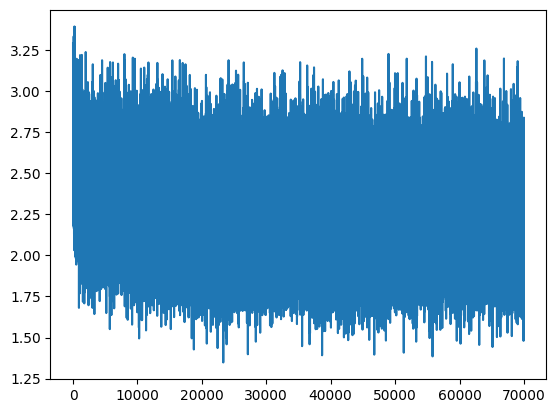

In [15]:
plt.plot(range(epochs + 1), losses)

In [16]:
@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xval, Yval),
      'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embed)
  embcat = emb.view(emb.shape[0], -1)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2070670127868652
val 2.2556307315826416


Prob - 2

Distribution of tanh heavily distributed at -1.00 and +1.00 which makes the grad = 0 as the grad through the tanh() is (1 - (t**2)) * X which becomes 0 if t == [-1,1]

This is also true in the case of sigmoid, tanh, ReLu, and so on

We could use leaky ReLu, ELU or Maxouts

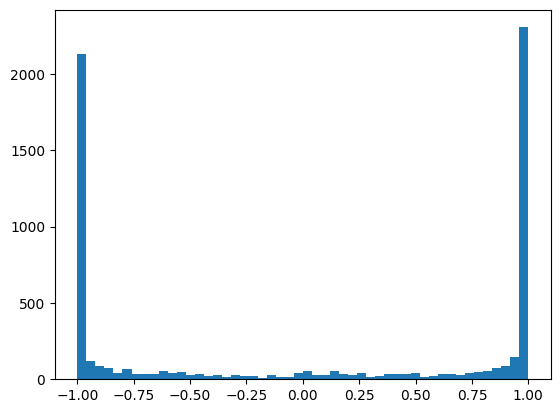

In [17]:
plt.hist(h.view(-1,).tolist(), bins = 50);

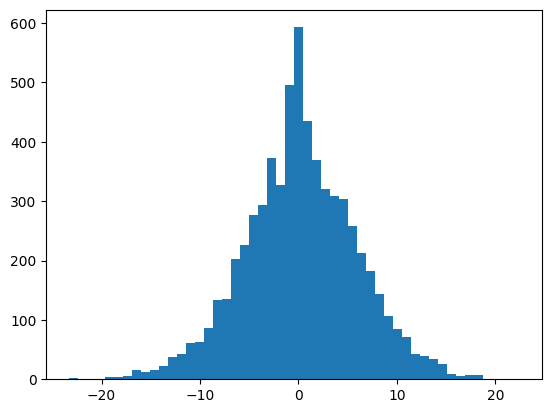

In [18]:
plt.hist(hpreact.view(-1,).tolist(), bins = 50);

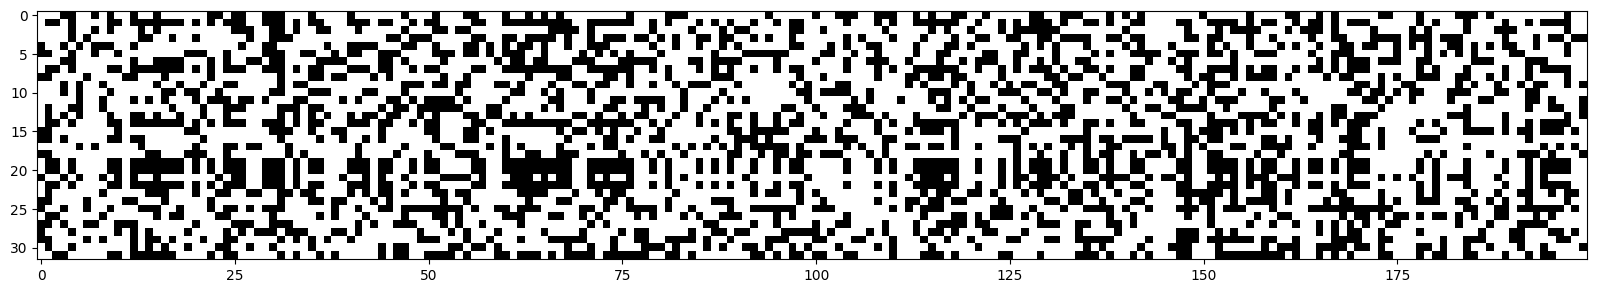

In [19]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation='nearest')

# white regions represents dead neurons

In [20]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)

# Weights and bias
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01            # Non-zero
b2 = torch.randn(vocab_size, generator=g) * 0                           # Since (+)

parameters = [C, W1, b1, W2, b2]

for params in parameters:
  params.requires_grad = True

In [21]:
  # forward pass
  emb = C[Xtr[ix]]   # (batch_size, 2, 3)
  embcat = emb.view(emb.shape[0], -1)   # (batch_size, 6)
  hpreact = embcat @ W1 + b1  # (batch_size, n_hidden)
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2   # (batch_size, vocab_size)
  loss = F.cross_entropy(logits, Ytr[ix])

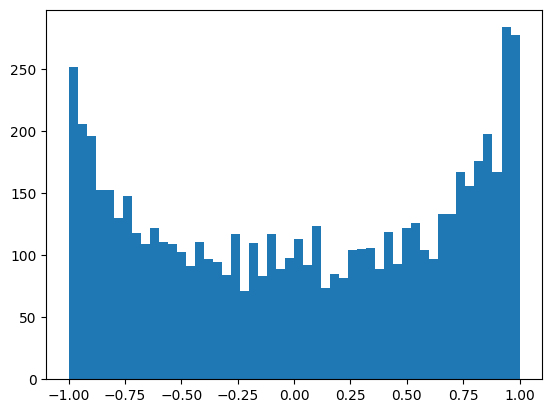

In [22]:
plt.hist(h.view(-1,).tolist(), bins = 50);

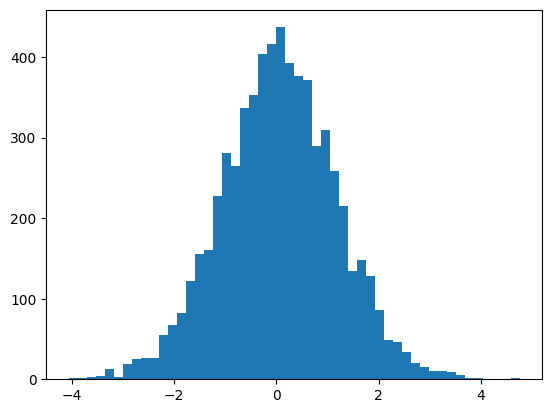

In [23]:
plt.hist(hpreact.view(-1,).tolist(), bins = 50);

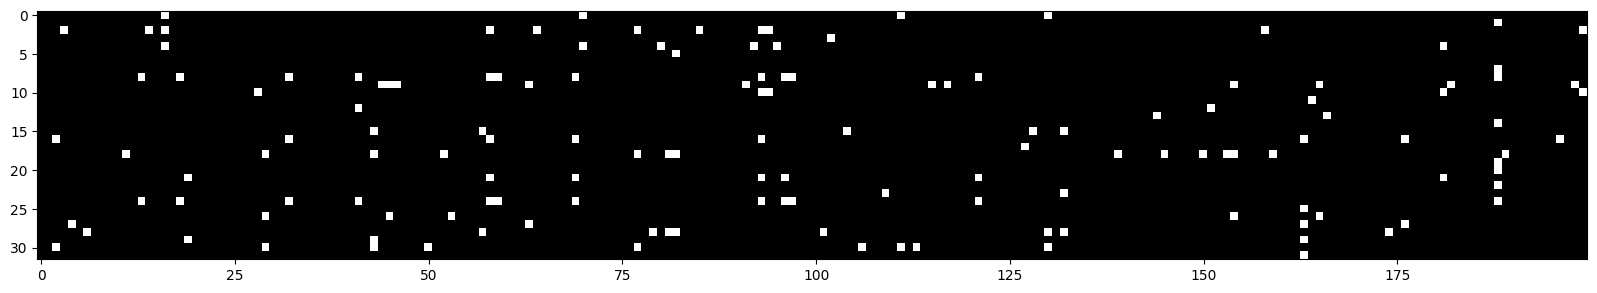

In [24]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation='nearest')

# white regions represents dead neurons

In [25]:
lr = 0.12
epochs = 70000
batch_size = 32
losses = []

for epoch in range(epochs + 1):

  # minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))

  # forward pass
  emb = C[Xtr[ix]]   # (batch_size, 2, 3)
  embcat = emb.view(emb.shape[0], -1)   # (batch_size, 6)
  hpreact = embcat @ W1 + b1  # (batch_size, n_hidden)
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2   # (batch_size, vocab_size)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update parameters
  for p in parameters:
    p.data += -lr * p.grad

  if epoch % 10000 == 0:
    print(f'{epoch} / {epochs}: {loss.item() : .4f}')
  losses.append(loss.item())

0 / 70000:  3.2966
10000 / 70000:  2.1327
20000 / 70000:  2.4966
30000 / 70000:  2.2114
40000 / 70000:  2.0867
50000 / 70000:  2.0821
60000 / 70000:  2.2791
70000 / 70000:  2.0577


In [26]:
@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xval, Yval),
      'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embed)
  embcat = emb.view(emb.shape[0], -1)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1642606258392334
val 2.2158749103546143


### **RESULT :**

**Original :**
- train 2.319
- val 2.378

**After setting up a proper initialisation :**
- train 2.207
- val 2.274

**After solving tanh decomposition :**
- train 2.164
- val 2.225


**Principled way**

How does the distribution change with different normalising constant

We need a same distribution for both x and y (i.e) same mean and standard deviation

**(i) Multiplying w with 1**

tensor(-0.0001) tensor(1.0008)
tensor(0.0129) tensor(5.5542)


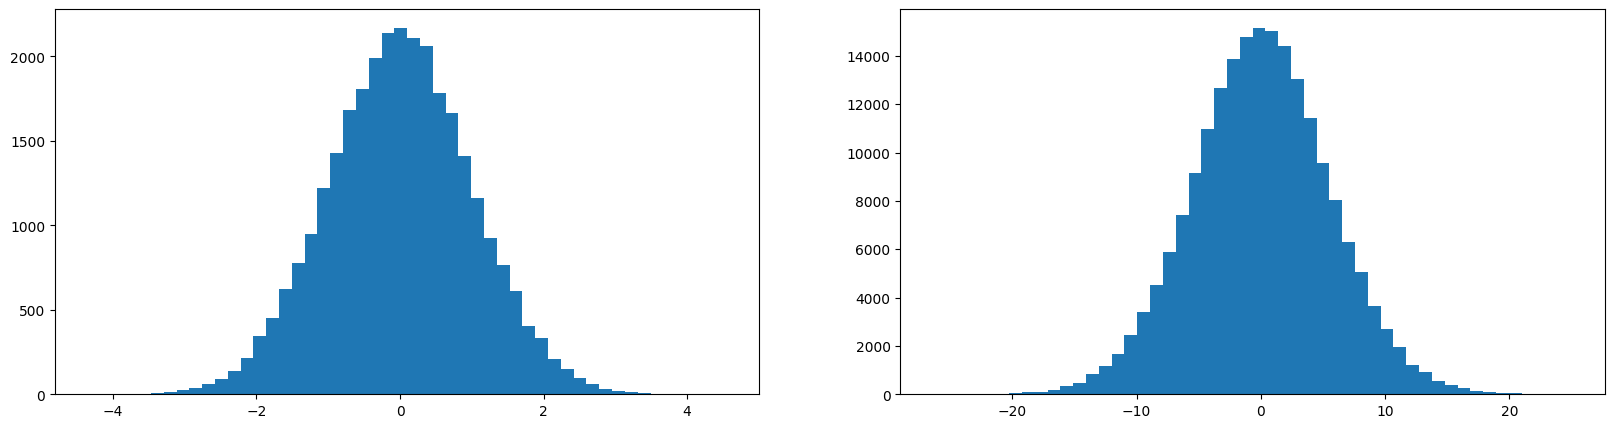

In [27]:
x = torch.randn((1000, 30))
w = torch.randn((30, 200))
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(x.view(-1,).tolist(), bins = 50);
plt.subplot(1,2,2)
plt.hist(y.view(-1,).tolist(), bins = 50);

**(ii) Multiplying w with 5**

std.dev increases

tensor(-0.0075) tensor(0.9947)
tensor(0.0539) tensor(27.4999)


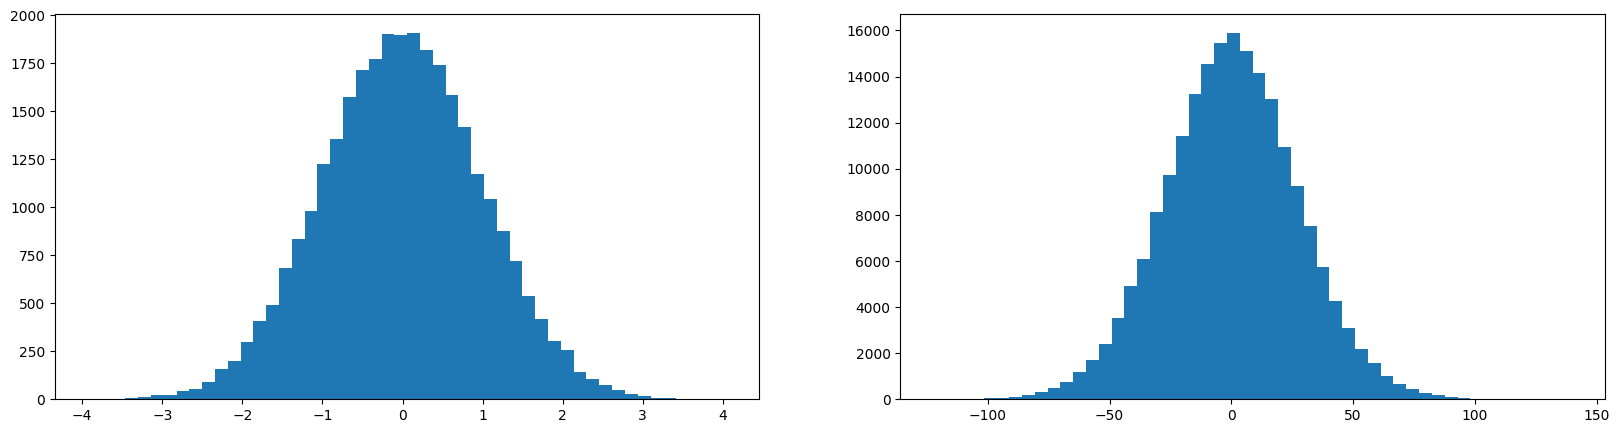

In [28]:
x = torch.randn((1000, 30))
w = torch.randn((30, 200)) * 5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(x.view(-1,).tolist(), bins = 50);
plt.subplot(1,2,2)
plt.hist(y.view(-1,).tolist(), bins = 50);

**(iii) Multiplying w with 0.2**

std.dev decreases

tensor(-0.0030) tensor(1.0035)
tensor(6.8975e-05) tensor(0.0559)


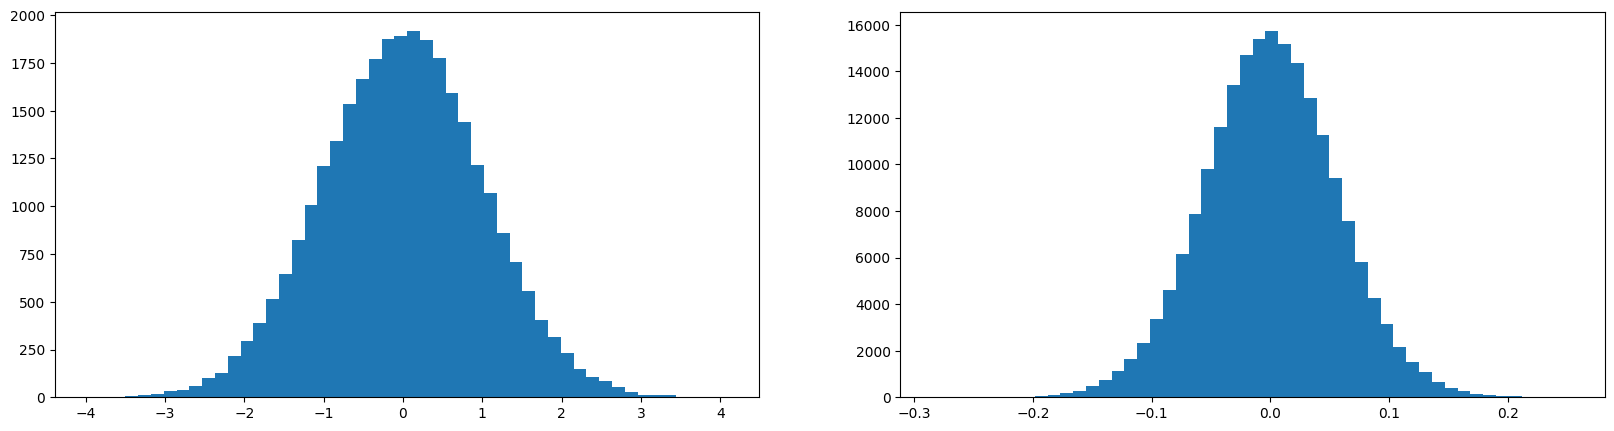

In [29]:
x = torch.randn((1000, 30))
w = torch.randn((30, 200)) * 0.01
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(x.view(-1,).tolist(), bins = 50);
plt.subplot(1,2,2)
plt.hist(y.view(-1,).tolist(), bins = 50);

**(iv) Dividing it with sqrt(fallin)**

std.dev(y) ~= std.dev(x)

tensor(-0.0071) tensor(0.9924)
tensor(-0.0003) tensor(0.9915)


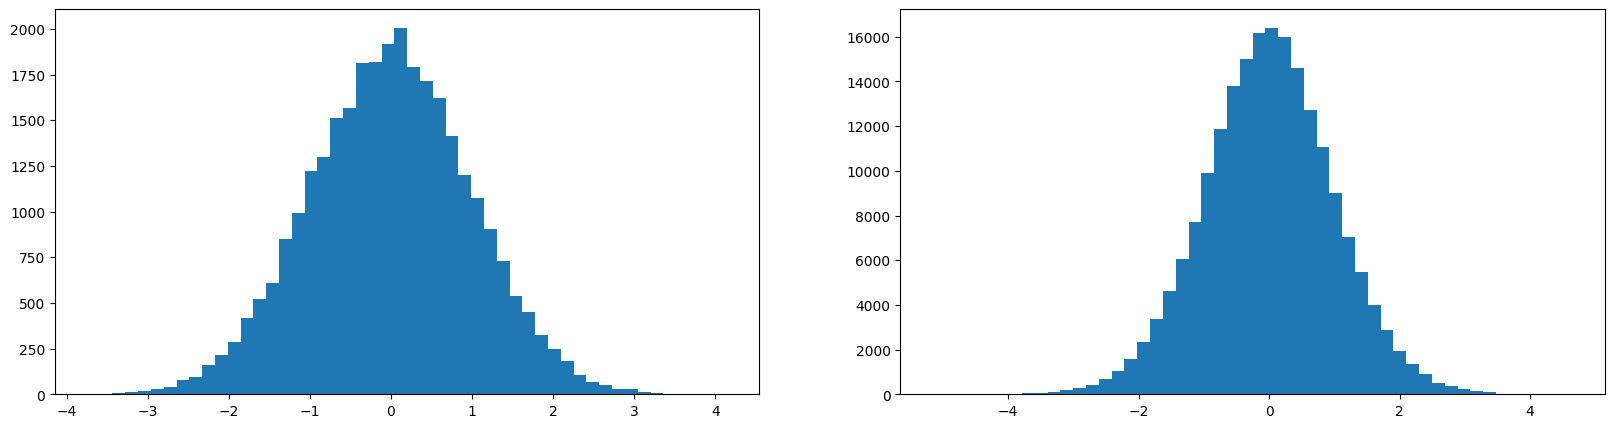

In [30]:
x = torch.randn((1000, 30))
w = torch.randn((30, 200)) / (30 ** 0.5) * 1     # kaiming init
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(x.view(-1,).tolist(), bins = 50);
plt.subplot(1,2,2)
plt.hist(y.view(-1,).tolist(), bins = 50);

## **Kaiming init**

For getting a equal distribution, multiply the random weights by std

where std = gain * (sqrt(fallin))

here,
  - for linear act.func => gain = 1
  - for non-linear act.func(tanh) => gain = (5/3)

In [31]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)

# Weights and bias
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * (5/3) / (n_emb * block_size) ** 0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01            # Non-zero
b2 = torch.randn(vocab_size, generator=g) * 0                           # Since (+)

parameters = [C, W1, b1, W2, b2]

for params in parameters:
  params.requires_grad = True

In [32]:
lr = 0.12
epochs = 70000
batch_size = 32
losses = []

for epoch in range(epochs + 1):

  # minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))

  # forward pass
  emb = C[Xtr[ix]]   # (batch_size, 2, 3)
  embcat = emb.view(emb.shape[0], -1)   # (batch_size, 6)
  hpreact = embcat @ W1 + b1  # (batch_size, n_hidden)
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2   # (batch_size, vocab_size)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update parameters
  for p in parameters:
    p.data += -lr * p.grad

  if epoch % 10000 == 0:
    print(f'{epoch} / {epochs}: {loss.item() : .4f}')
  losses.append(loss.item())


0 / 70000:  3.3091
10000 / 70000:  1.9785
20000 / 70000:  2.2420
30000 / 70000:  2.5354
40000 / 70000:  2.3419
50000 / 70000:  2.1785
60000 / 70000:  2.0619
70000 / 70000:  2.1564


In [33]:
@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xval, Yval),
      'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embed)
  embcat = emb.view(emb.shape[0], -1)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1495583057403564
val 2.195878505706787


## **Batch normalisation**

Gonna make the pre-activation hpreact as unit-gaussian

(i.e) for each y in hpreact

y_new = ${\frac{(y - mean(of the batch))}{ std(of the batch)}}$


In [34]:
hpreact.shape

torch.Size([32, 200])

In [35]:
(hpreact.mean(dim = 0, keepdim = True).shape,
 hpreact.std(dim = 0, keepdim = True).shape)

(torch.Size([1, 200]), torch.Size([1, 200]))

In [36]:
lr = 0.12
epochs = 70000
batch_size = 32
losses = []

for epoch in range(epochs + 1):

  # minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))

  # forward pass
  emb = C[Xtr[ix]]   # (batch_size, 2, 3)
  embcat = emb.view(emb.shape[0], -1)   # (batch_size, 6)
  # ----
  hpreact = (embcat @ W1 + b1)
  hpreact = (hpreact - hpreact.mean(dim = 0, keepdim = True)) / hpreact.std(dim = 0, keepdim = True)
  # ----
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2   # (batch_size, vocab_size)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update parameters
  for p in parameters:
    p.data += -lr * p.grad

  if epoch % 10000 == 0:
    print(f'{epoch} / {epochs}: {loss.item() : .4f}')
  losses.append(loss.item())

0 / 70000:  2.6796
10000 / 70000:  1.8722
20000 / 70000:  2.3452
30000 / 70000:  2.1910
40000 / 70000:  2.1967
50000 / 70000:  2.8433
60000 / 70000:  2.3519
70000 / 70000:  1.8471


But we need the batch normalisation only during initialisation

So, we offset the gained y as

y_new = $(\gamma * Y) + β$

In [37]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)

# Weights and bias
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * (5/3) / (n_emb * block_size) ** 0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01            # Non-zero
b2 = torch.randn(vocab_size, generator=g) * 0                           # Since (+)

batch_gain = torch.ones((1, n_hidden))
batch_bias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, batch_gain, batch_bias]

for params in parameters:
  params.requires_grad = True

In [38]:
lr = 0.12
epochs = 70000
batch_size = 32
losses = []

for epoch in range(epochs + 1):

  # minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))

  # forward pass
  emb = C[Xtr[ix]]   # (batch_size, 2, 3)
  embcat = emb.view(emb.shape[0], -1)   # (batch_size, 6)
  # ----
  hpreact = (embcat @ W1 + b1)
  hpreact = batch_gain * (hpreact - hpreact.mean(dim = 0, keepdim = True)) / hpreact.std(dim = 0, keepdim = True) + batch_bias
  # ----
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2   # (batch_size, vocab_size)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update parameters
  for p in parameters:
    p.data += -lr * p.grad

  if epoch % 10000 == 0:
    print(f'{epoch} / {epochs}: {loss.item() : .4f}')
  losses.append(loss.item())

0 / 70000:  3.2799
10000 / 70000:  2.6874
20000 / 70000:  1.9520
30000 / 70000:  1.8459
40000 / 70000:  2.2642
50000 / 70000:  2.2090
60000 / 70000:  2.1239
70000 / 70000:  2.1205


In [39]:
@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xval, Yval),
      'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embed)
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  hpreact = batch_gain * (hpreact - hpreact.mean(dim = 0, keepdim = True)) / hpreact.std(dim = 0, keepdim = True) + batch_bias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.166491746902466
val 2.1924960613250732


Now the neural net expects a batch always as it computes mean and std now and if we want to give a single input to the neural net, then it will throw error

So we can calibrate the entire mean and std after the training and then use this mean and std for testing


In [40]:
# calibrate batch norm at the end of training set

with torch.no_grad():
  # passing the training set
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1

  # measure the mean/std over the entire training set
  batch_mean = hpreact.mean(dim = 0, keepdim = True)
  batch_std = hpreact.std(dim = 0, keepdim = True)

In [41]:
@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xval, Yval),
      'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embed)
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  hpreact = batch_gain * ((hpreact - batch_mean) / batch_std) + batch_bias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.166491746902466
val 2.192749500274658


**Combining the above two steps into a single process**

In [42]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)

# Weights and bias
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * (5/3) / (n_emb * block_size) ** 0.5
#b1 = torch.randn(n_hidden, generator=g) * 0.01

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01            # Non-zero
b2 = torch.randn(vocab_size, generator=g) * 0                           # Since (+)

batch_gain = torch.ones((1, n_hidden))
batch_bias = torch.zeros((1, n_hidden))
batch_mean_running = torch.zeros((1, n_hidden))
batch_std_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, batch_gain, batch_bias]

for params in parameters:
  params.requires_grad = True

In [43]:
lr = 0.12
epochs = 70000
batch_size = 32
losses = []

for epoch in range(epochs + 1):

  # minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))

  # forward pass
  emb = C[Xtr[ix]]   # (batch_size, 2, 3)
  embcat = emb.view(emb.shape[0], -1)   # (batch_size, 6)
  # ----
  hpreact = (embcat @ W1)     # removed the bias as batch_bias is gonna do it
  bmeani = hpreact.mean(dim = 0, keepdim = True)
  bstdi = hpreact.std(dim = 0, keepdim = True)
  hpreact = batch_gain * (hpreact - bmeani) / bstdi + batch_bias

  with torch.no_grad():
    batch_mean_running = 0.999 * batch_mean_running + 0.001 * bmeani
    batch_std_running = 0.999 * batch_std_running + 0.001 * bstdi

  # ----
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2   # (batch_size, vocab_size)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update parameters
  for p in parameters:
    p.data += -lr * p.grad

  if epoch % 10000 == 0:
    print(f'{epoch} / {epochs}: {loss.item() : .4f}')
  losses.append(loss.item())

0 / 70000:  3.2773
10000 / 70000:  2.2810
20000 / 70000:  2.5000
30000 / 70000:  2.3641
40000 / 70000:  2.1466
50000 / 70000:  2.2869
60000 / 70000:  1.8743
70000 / 70000:  2.4480


In [44]:
print(f'batch_mean(for first 5 samples) => {batch_mean[0][:5]}\nbatch_mean_running(for first 5 samples) => {batch_mean_running[0][:5]}')

batch_mean(for first 5 samples) => tensor([-2.4477,  0.1569, -1.3874,  0.9608,  0.9248])
batch_mean_running(for first 5 samples) => tensor([-1.9265, -0.0036, -1.8868,  1.0453,  1.0878])


In [45]:
print(f'batch_std(for first 5 samples) => {batch_std[0][:5]}\nbatch_std_running(for first 5 samples) => {batch_std_running[0][:5]}')

batch_std(for first 5 samples) => tensor([2.3810, 2.0919, 1.7953, 2.0465, 2.2169])
batch_std_running(for first 5 samples) => tensor([2.2231, 1.9891, 1.8905, 1.9333, 2.0468])


In [46]:
@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xval, Yval),
      'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embed)
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  hpreact = batch_gain * ((hpreact - batch_mean_running) / batch_std_running) + batch_bias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1676132678985596
val 2.197421073913574
